# Run the x-match using the GC method

The "great-circle" x-matching method was implemented on `booq`, but merging the _matched_ catalog with the _A,B source_ ones is showing some problems. We go now through a step-by-step onto the process to find out what's going on.

In [1]:
import booq

In [2]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import cm

import numpy

plt.rcParams['figure.figsize'] = (10.0, 10.0) 

In [3]:
# let's define some parameters for our mock catalogs

# to be real fake, we have to fake evrything... :(
# let's start with the size of the supposed images
# from where the sources are coming from...
sx = 300
sy = 300

# number of sources to be relative to the size of the image
num_sources = int( 0.1 * (sx*sy)/(sx+sy) )

# and, say there is an error radius
error_radius = 20

In [20]:
from booq.data import mock
from booq import coordinates

# Generate catalog A
A_image_catalog = mock.D2.generate_catalog(num_sources, error_radius, (sy,sx))

A = A_image_catalog.rename(columns={'ID':'id'})
A.loc[:,'ra']  = coordinates.pixel_to_sky(A_image_catalog.x, 0, 1.0/sx)
A.loc[:,'dec'] = coordinates.pixel_to_sky(A_image_catalog.y, 0, 1.0/sy)

# Generate catalog B
B_image_catalog = mock.D2.generate_catalog_around(A_image_catalog.sample(frac=0.75),
                                                  0.75, (sy,sx))

B = B_image_catalog.rename(columns={'ID':'id'})
B.loc[:,'ra']  = coordinates.pixel_to_sky(B_image_catalog.x, 0, 1.0/sx)
B.loc[:,'dec'] = coordinates.pixel_to_sky(B_image_catalog.y, 0, 1.0/sy)


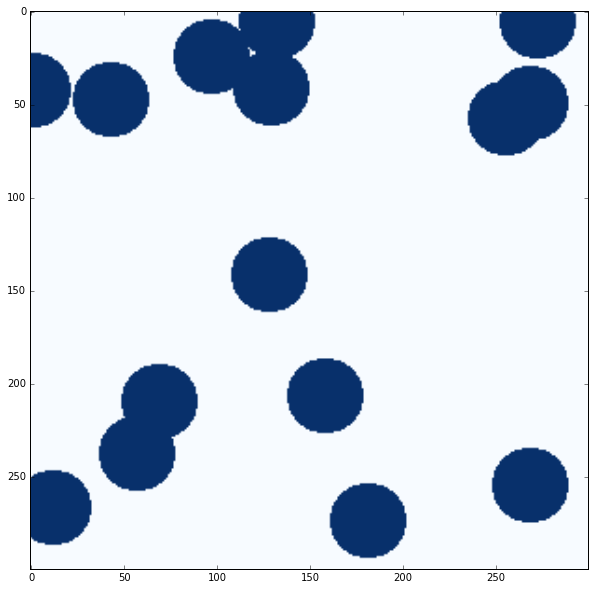

In [21]:
from matplotlib import pyplot as plt
from booq import image
imgA = image.pil.draw_sources(A,(sy,sx),colormap='blue')
imgA = image.pil.pil_2_array(imgA)
plt.imshow(image.rgb_2_mono(imgA,'B'), cmap='Blues')

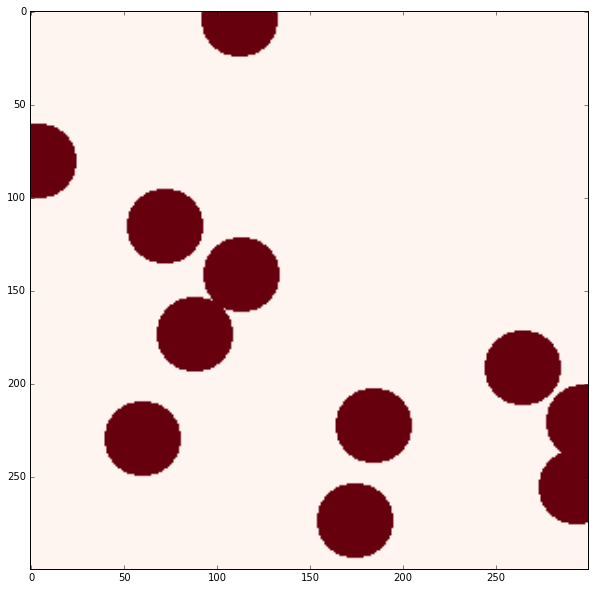

In [22]:
from matplotlib import pyplot as plt
from booq import image
imgB = image.pil.draw_sources(B,(sy,sx),colormap='red')
imgB = image.pil.pil_2_array(imgB)
plt.imshow(image.rgb_2_mono(imgB,'R'), cmap='Reds')

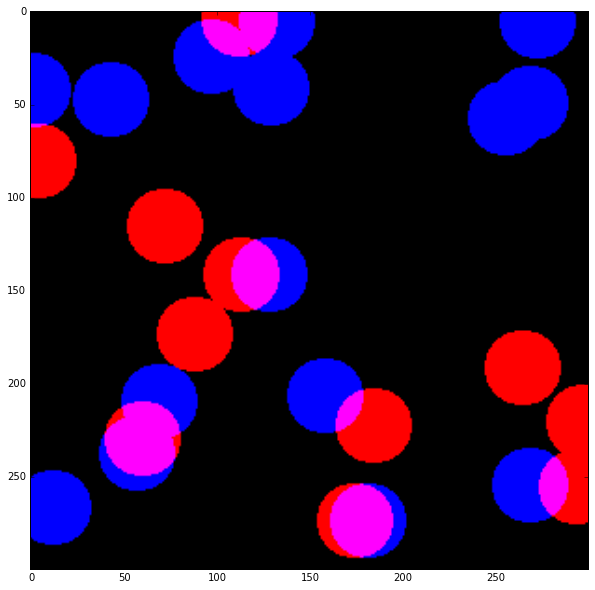

In [23]:
plt.imshow( image.pil.array_2_pil( imgA+imgB ) )

In [24]:
A.describe()

,id,r,x,y,ra,dec
count,15.000000,15.0,15.000000,15.000000,15.000000,15.000000
mean,15.800000,20.0,138.000000,124.733333,0.460000,0.415778
std,8.620573,0.0,94.333754,104.965618,0.314446,0.349885
min,2.000000,20.0,1.000000,6.000000,0.003333,0.020000
25%,9.000000,20.0,63.000000,42.500000,0.210000,0.141667
50%,16.000000,20.0,129.000000,58.000000,0.430000,0.193333
75%,22.500000,20.0,218.000000,224.000000,0.726667,0.746667
max,29.000000,20.0,272.000000,274.000000,0.906667,0.913333


In [25]:
B.describe()

,id,r,x,y,ra,dec
count,11.000000,11.0,11.000000,11.000000,11.000000,11.000000
mean,10.363636,20.0,151.000000,174.000000,0.503333,0.580000
std,5.971143,0.0,99.464567,81.481286,0.331549,0.271604
min,1.000000,20.0,4.000000,5.000000,0.013333,0.016667
25%,6.000000,20.0,80.000000,129.000000,0.266667,0.430000
50%,11.000000,20.0,113.000000,192.000000,0.376667,0.640000
75%,14.000000,20.0,224.000000,226.500000,0.746667,0.755000
max,20.000000,20.0,297.000000,274.000000,0.990000,0.913333


In [26]:
from booq.coordinates.skycoords import skycoords
A_coord = skycoords(A.ra.values, A.dec.values)
B_coord = skycoords(B.ra.values, B.dec.values)

In [27]:
from booq.catalogs import xmatch
_Aidx,_Asep = xmatch.nn(A_coord,B_coord)
_Bidx,_Bsep = xmatch.nn(B_coord,A_coord)
_sep = numpy.append(_Asep.arcmin,_Bsep.arcmin)
from booq.utils import stats
_sts = stats.basic(_sep)
from booq import utils
utils.pprint(_sts)
del _Aidx,_Asep,_Bidx,_Bsep,_sep,_sts

length : 26
min : 1.39982213021
max : 32.0006233512
mean : 8.72629855259
std : 8.0704735842
quantiles : (4.0049966738216174, 6.105388417332942, 9.8974916837027163)


In [28]:
from astropy.units import Quantity
radius = Quantity(8,'arcmin')

In [29]:
from booq.catalogs import xmatch
match_A_gc_idx, match_B_gc_idx, match_gc_sep = xmatch.gc(A_coord, B_coord, radius)

In [30]:
from booq import utils
utils.pprint(utils.stats.basic(match_gc_sep.arcmin))

length : 9
min : 1.39982213021
max : 7.62364710421
mean : 4.24802897442
std : 1.89081900191
quantiles : (2.9998976288148471, 4.3862818990480994, 5.0034464770214324)


In [31]:
from booq.pipelines import xmatch_nn
reload(xmatch_nn)
df_matched_idx = xmatch_nn.select_pairs(match_A_gc_idx, match_B_gc_idx, match_gc_sep.arcmin)
df_matched_idx

,A_idx,B_duplicates,B_idx,separation,to_drop
0,0,None,7,4.999999,False
1,3,None,2,2.999898,False
2,6,None,9,5.003446,False
3,7,None,3,4.386282,False
4,8,None,0,7.623647,False
5,9,None,6,1.399822,False
6,11,None,10,6.105388,False
7,12,None,7,4.004997,False
8,14,None,3,1.708781,False


In [32]:
# def recover_id(indexes,df,id_column):
# #     print "input:",indexes
#     inds = [ int(n) for n in indexes.split(';') ]
# #     print "toint:",inds
#     from numpy import unique
#     ids = ';'.join(unique([ str(n) for n in df.loc[inds,id_column] ]))
# #     print "toids:",ids
# #     print
#     return ids

# def pkg_recover_id(df,id_column):
#     def pkg(indexes,df=df,id_column=id_column):
#         return recover_id(indexes,df,id_column)
#     return pkg

# recover_id_pkg = pkg_recover_id(B_matched,'id')

In [33]:
# AB_match = DataFrame( {'dist':df_matched_idx.separation.values},
#                         index=df_matched_idx.A_idx.values )
# if 'B_duplicates' in df_matched_idx.columns:
#     for i,row in df_matched_idx.iterrows():
#         entry = row.B_duplicates
#         if entry is None:
#             continue
#         inds = [ int(n) for n in entry.split(';') ]
#         ids = ';'.join([ str(n) for n in B.loc[inds,'id'] ])
#         df_matched_idx.loc[i,'B_duplicates'] = ids
#     AB_match.loc[:,'B_duplicates'] = df_matched_idx.B_duplicates.values

# B_matched = B.iloc[df_matched_idx.B_idx]
# B_matched.loc[:,'A_idx'] = df_matched_idx.A_idx.values

# B_matched = B_matched.set_index('A_idx')

# from pandas import DataFrame,concat
# df = concat([ A, B_matched, AB_match ], axis=1, keys=['A','B','AB'])

In [34]:
df = matched_catalog = xmatch_nn.merge_catalogs(A, B, df_matched_idx)

In [35]:
df

A                                       B                                \
    id   r    x    y        ra       dec    id     r      x      y        ra   
0   22  20   97   25  0.323333  0.083333   1.0  20.0  112.0    5.0  0.373333   
1   18  20   12  267  0.040000  0.890000   NaN   NaN    NaN    NaN       NaN   
2   24  20  255   58  0.850000  0.193333   NaN   NaN    NaN    NaN       NaN   
3   14  20  128  142  0.426667  0.473333  13.0  20.0  113.0  142.0  0.376667   
4   29  20  129   42  0.430000  0.140000   NaN   NaN    NaN    NaN       NaN   
5   23  20  272    6  0.906667  0.020000   NaN   NaN    NaN    NaN       NaN   
6   11  20  268  255  0.893333  0.850000  12.0  20.0  293.0  256.0  0.976667   
7    7  20   69  210  0.230000  0.700000  11.0  20.0   60.0  230.0  0.200000   
8    2  20    1   43  0.003333  0.143333   4.0  20.0    4.0   81.0  0.013333   
9   21  20  181  274  0.603333  0.913333  17.0  20.0  174.0  274.0  0.580000   
10  10  20  268   50  0.893333  0.166667   NaN   NaN    NaN    NaN       NaN   
11  16  20  158  207  0.526667  0.690000   3.0  20.0  184.0  223.0  0.613333   
12   4  20  132    6  0.440000  0.020000   1.0  20.0  112.0    5.0  0.373333   
13  28  20   43   48  0.143333  0.160000   NaN   NaN    NaN    NaN       NaN   
14   8  20   57  238  0.190000  0.793333  11.0  20.0   60.0  230.0  0.200000   

                    AB               
         dec      dist B_duplicates  
0   0.016667  4.999999         None  
1        NaN       NaN         None  
2        NaN       NaN         None  
3   0.473333  2.999898         None  
4        NaN       NaN         None  
5        NaN       NaN         None  
6   0.853333  5.003446         None  
7   0.766667  4.386282         None  
8   0.270000  7.623647         None  
9   0.913333  1.399822         None  
10       NaN       NaN         None  
11  0.743333  6.105388         None  
12  0.016667  4.004997         None  
13       NaN       NaN         None  
14  0.766667  1.708781         None